In [47]:
import os, sys
sys.path.append(os.path.expanduser(os.path.join("~", "Projects", "birkhoff")))

import numpy as np
from scipy.misc import logsumexp

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [38]:
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

color_names = ["red",
               "windows blue",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "light cyan",
               "steel blue",
               "pastel purple",
               "mint",
               "salmon"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("paper")

from scipy.optimize import linear_sum_assignment

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.optimizers import adam

from birkhoff.primitives import \
    logit, logistic, gaussian_logp, gaussian_entropy, \
    psi_to_birkhoff, log_det_jacobian, birkhoff_to_psi, \
    birkhoff_to_perm

In [3]:
# Global parameters
npr.seed(0)
K = 30
D = 2
eta = 0.5
sigma_min, sigma_max = 1e-8, 1.0

# Optimization parameters
num_adam_iters = 500
num_mcmc_samples = 10

# Sample a true permutation (in=col, out=row)
# perm_true = npr.permutation(K)
perm_true = np.arange(K)[::-1]
P_true = np.zeros((K, K))
P_true[np.arange(K), perm_true] = 1

# Sample data according to this permutation
xs = npr.randn(K, D)
xs_perm = P_true.T.dot(xs)
ys = xs_perm + eta * npr.randn(K, D)


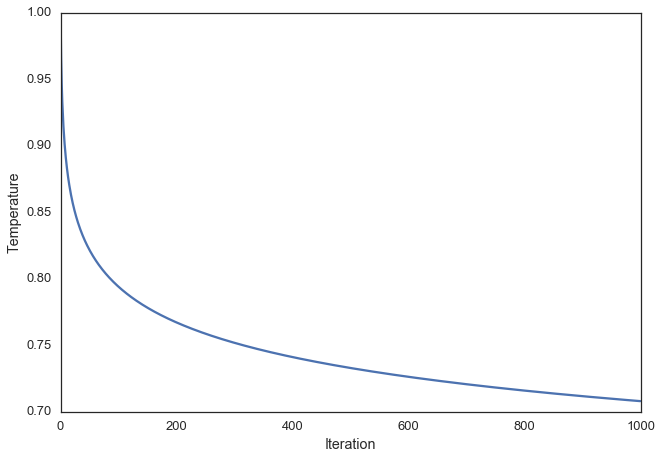

In [4]:

# Anneal the temperature
def temperature(t, c=-0.25):
    T = np.size(t)
    return (np.arange(T)+1)**c


# def temperature(t, c=-0.25):
#     T = np.size(t)
#     tau = np.ones(T) * (t < 100)
#     tau += 0.95 * np.ones(T) * np.bitwise_and(t >= 100, t < 200)
#     tau += 0.9 * np.ones(T) * np.bitwise_and(t >= 200, t < 300)
#     tau += 0.85 * np.ones(T) * np.bitwise_and(t >= 300, t < 400)
#     tau += 0.8 * np.ones(T) * np.bitwise_and(t >= 400, t < 500)
#     tau += 0.8 * np.ones(T) * (t >= 500)
#     return tau

# def temperature(t, c=-0.25):
#     T = np.size(t)
#     tau = np.ones(T)
#     return tau

t = np.arange(1000)
plt.plot(t, temperature(t, c=-0.05))
# plt.plot(t, temperature(t, c=-0.25))
# plt.plot(t, temperature(t, c=-0.5))
plt.xlabel("Iteration")
plt.ylabel("Temperature")

([], <a list of 0 Text yticklabel objects>)

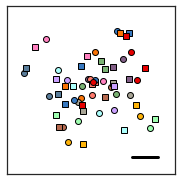

In [5]:
# Plot to and from
fig = plt.figure(figsize=(3,3))
lim = max(abs(ys).max(), abs(xs).max())
for k in range(K):
    plt.plot(xs[k, 0], xs[k, 1], 'o',
             color=colors[k % len(colors)],  markersize=6,
             markeredgecolor='k', markeredgewidth=1)
    plt.plot(ys[perm_true[k], 0], ys[perm_true[k], 1], 's',
             markersize=6, color=colors[k % len(colors)],
             markeredgecolor='k', markeredgewidth=1)

# Scale bar
plt.plot([lim-2*eta,lim], [-lim,-lim], '-k', lw=3)

plt.xlim([-1.25*lim, 1.25*lim])
plt.ylim([-1.25*lim, 1.25*lim])
plt.xticks([])
plt.yticks([])

In [42]:
# Compute the MAP assignment
score = np.zeros((K, K))
for i in range(K):
    for j in range(K):
#         score[i,j] = -0.5 * np.sum((ys[j] - xs[i])**2) / eta**2 
        score[i,j] = np.sum(gaussian_logp(ys[j], xs[i], eta))
row, col = linear_sum_assignment(-score)
P_map = np.zeros((K, K))
P_map[row, col] = 1

In [7]:
# Build variational objective. The variational dist is 
# a diagonal Gaussian over the (K-1)**2 parameters
def unpack_params(params):
    assert params.shape == (2 * (K - 1)**2, )
    q_mu = np.reshape((params[:(K-1)**2]), (K-1, K-1))
    q_logit_sigma = np.reshape((params[(K-1)**2:]), (K-1, K-1))
    q_sigma = sigma_min + (sigma_max - sigma_min) * logistic(q_logit_sigma)
    q_log_sigma = np.log(q_sigma)
    return q_mu, q_log_sigma, q_sigma


# Set up the log probability objective
# Assume a uniform prior on P?
# Right now this is just the likelihood...
def log_prob(P, t):
    return np.sum(gaussian_logp(ys, np.dot(P.T, xs), eta))
    
def variational_objective(params, t):
    """Provides a stochastic estimate of the variational lower bound."""
    q_mu, q_log_sigma, q_sigma = unpack_params(params)
    Psi_samples = q_mu + npr.randn(num_mcmc_samples, K-1, K-1) * q_sigma
    P_samples = [psi_to_birkhoff(logistic(Psi / temperature(t))) 
                 for Psi in Psi_samples]

    # Compute ELBO. Explicitly compute gaussian entropy.
    elbo = 0
    for P, Psi in zip(P_samples, Psi_samples):
        elbo = elbo + log_prob(P, t) / num_mcmc_samples
        elbo = elbo - log_det_jacobian(P) / num_mcmc_samples
        assert np.isfinite(elbo)

    elbo = elbo + gaussian_entropy(q_log_sigma)

    # Minimize the negative elbo
    return -elbo / (K-1)**2

gradient = grad(variational_objective)
elbos = []

def callback(params, t, g, perline=40):
    elbos.append(-variational_objective(params, t))
    if (t % perline) == 0:
        sys.stdout.write('. [Iter {0}/{1}] VLB: {2:.1f}\n'.format(t, num_adam_iters, elbos[-1]))
    else:
        sys.stdout.write('.')
    sys.stdout.flush()
    

In [8]:
print("Variational inference for matching...")
print("Initializing with MAP estimate")
P_center  = 1. / K * np.ones((K, K))
P_init = 0.05 * P_center + 0.95 * P_map
init_mean = birkhoff_to_psi(P_init).ravel()
init_mean = logit(init_mean)
init_logit_std = -3 * np.ones((K - 1) ** 2)
init_var_params = np.concatenate([init_mean, init_logit_std])

# SGD with Adam
variational_params = adam(gradient, init_var_params, 
                          step_size=0.1, num_iters=num_adam_iters, 
                          callback=callback)

Variational inference for matching...
Initializing with MAP estimate
. [Iter 0/500] VLB: 1187.6
........................................ [Iter 40/500] VLB: 1191.4
........................................ [Iter 80/500] VLB: 1191.8
........................................ [Iter 120/500] VLB: 1191.8
........................................ [Iter 160/500] VLB: 1191.8
........................................ [Iter 200/500] VLB: 1191.9
........................................ [Iter 240/500] VLB: 1191.9
........................................ [Iter 280/500] VLB: 1191.9
........................................ [Iter 320/500] VLB: 1191.9
........................................ [Iter 360/500] VLB: 1191.9
........................................ [Iter 400/500] VLB: 1191.9
........................................ [Iter 440/500] VLB: 1191.9
........................................ [Iter 480/500] VLB: 1191.9
...................

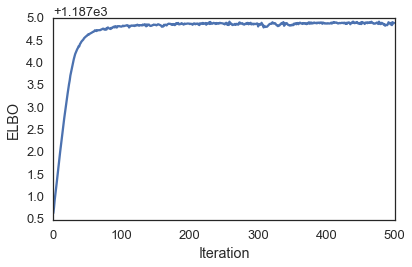

In [9]:
# Plot the elbo
plt.figure(figsize=(6,4))
plt.plot(elbos)
plt.xlim(0, num_adam_iters)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.tight_layout()

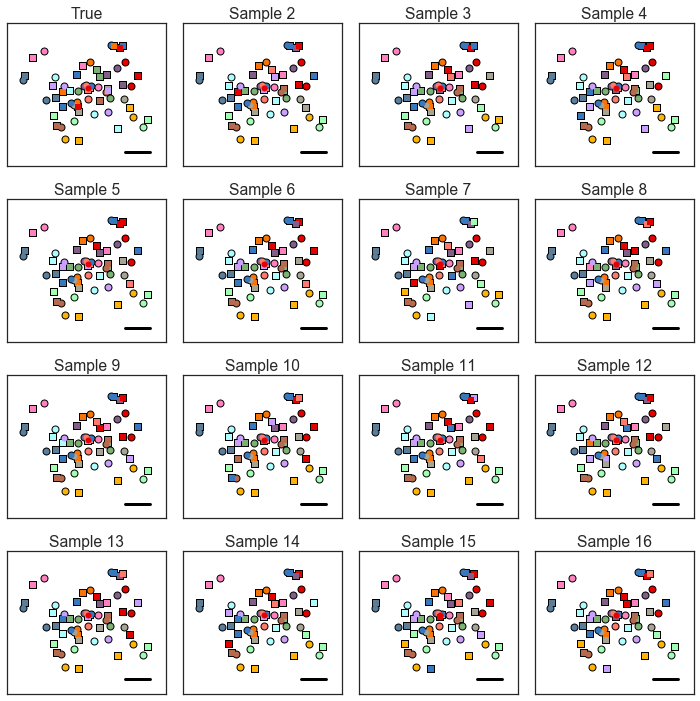

In [10]:
# Sample from the posterior and show samples
q_mu, _, q_sigma = unpack_params(variational_params)

lim = max(abs(ys).max(), abs(xs).max())

fig = plt.figure(figsize=(10, 10), facecolor='white')
for i in range(4):
    for j in range(4):
        Psi_sample = q_mu + npr.randn(K - 1, K - 1) * q_sigma
        P_sample = psi_to_birkhoff(logistic(Psi_sample / temperature(num_adam_iters)))
        # Round doubly stochastic matrix P to the nearest permutation matrix
        row, col = linear_sum_assignment(-P_sample)
        
        if (i == 0) and (j == 0):
            col = np.argmax(P_true, axis=1)

        ax = fig.add_subplot(4, 4, i*4 + j +1, frameon=True)
        for k in range(K):
            plt.plot(ys[k, 0], ys[k, 1], 'sk', markersize=8)
            plt.plot(xs[k, 0], xs[k, 1], 'ok', markersize=8)

        for k in range(K):
            plt.plot(xs[k, 0], xs[k, 1], 'o',
                     color=colors[k % len(colors)],  markersize=6)
            plt.plot(ys[col[k], 0], ys[col[k], 1], 's',
                     markersize=6, color=colors[k % len(colors)])

        # Scale bar
        plt.plot([lim-2*eta,lim], [-lim,-lim], '-k', lw=3)

        ax.set_xlim([-1.25*lim, 1.25*lim])
        ax.set_ylim([-1.25*lim, 1.25*lim])
        ax.set_xticks([])
        ax.set_yticks([])
        
        if (i==0) and (j==0):
            ax.set_title("True")
        else:
            ax.set_title("Sample {}".format(i*4+j+1))

plt.tight_layout()

In [11]:
# Enumerate all possible permutations and compute their probability
if K < 7:
    Kfac = np.prod(np.arange(1, K+1))

    post_true = {}
    import itertools as it
    for perm in it.permutations(np.arange(K)):
        P = np.zeros((K, K))
        P[np.arange(K), perm] = 1
        post_true[perm] = log_prob(P, 0)

    post_inf = {}
    for perm in it.permutations(np.arange(K)):
        post_inf[perm] = 0

    N_sample = 1000
    for s in range(N_sample):
        Psi_sample = q_mu + npr.randn(K - 1, K - 1) * sigma_post
        P_sample = psi_to_birkhoff(logistic(Psi_sample / temperature(num_adam_iters)))
        # Round doubly stochastic matrix P to the nearest permutation matrix
        row, col = linear_sum_assignment(-P_sample)
        post_inf[tuple(col)] += 1

    # Convert to arrays
    post_true_vec = np.zeros(Kfac)
    post_inf_vec = np.zeros(Kfac)
    for i, perm in enumerate(it.permutations(np.arange(K))):
        post_true_vec[i] = post_true[perm]
        post_inf_vec[i] = post_inf[perm]

    from scipy.misc import logsumexp
    post_true_vec = np.exp(post_true_vec - logsumexp(post_true_vec))
    post_inf_vec = post_inf_vec / post_inf_vec.sum()
    sort = np.argsort(-post_true_vec)
    post_true_vec = post_true_vec[sort]
    post_inf_vec = post_inf_vec[sort]

    trunc = 20
    trunc_post_true_vec = np.concatenate((post_true_vec[:trunc], 
                                          [post_true_vec[trunc:].sum()]))

    trunc_post_inf_vec = np.concatenate((post_inf_vec[:trunc], 
                                         [post_inf_vec[trunc:].sum()]))

    plt.figure(figsize=(4,2))
    plt.bar(np.arange(trunc+1), trunc_post_true_vec, width=0.4, color=colors[0], label="true")
    plt.bar(np.arange(trunc+1)+0.4, trunc_post_inf_vec, width=0.4, color=colors[1], label="inf")
    plt.legend(loc="upper right")
    plt.xlim(0, trunc+1)

else:
    print("Can only empirically compute exact permutation probability for small K")

Can only empirically compute permutation probability for small K


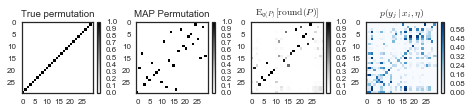

In [66]:
class_inf = np.zeros((K, K))

N_sample = 1000
for s in range(N_sample):
    Psi_sample = q_mu + npr.randn(K - 1, K - 1) * q_sigma
    B_sample = psi_to_birkhoff(logistic(Psi_sample / temperature(num_adam_iters)))
    P_sample = birkhoff_to_perm(B_sample)
    class_inf += P_sample

class_inf /= float(N_sample)
    
fig = plt.figure(figsize=(6.5,2.))
ax1 = plt.subplot(141)
im1 = plt.imshow(P_true, interpolation="nearest")
plt.title("True permutation")

divider = make_axes_locatable(ax1)
cb1 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb1)
plt.colorbar(im1, cax=cb1)

ax2 = plt.subplot(142)
im2 = plt.imshow(P_map, interpolation="nearest")
plt.title("MAP Permutation")

divider = make_axes_locatable(ax2)
cb2 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb2)
plt.colorbar(im2, cax=cb2)

ax3 = plt.subplot(143)
im3 = plt.imshow(class_inf, vmin=0, vmax=1, interpolation="nearest")
ax3.set_title("$\mathrm{E}_{q(P)}[\mathrm{round}(P)]$")

divider = make_axes_locatable(ax3)
cb3 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb3)
plt.colorbar(im3, cax=cb3)

ax4 = plt.subplot(144)
im4 = plt.imshow(np.exp(score), interpolation="nearest",cmap="Blues")
ax4.set_title("$p(y_j \\mid x_i, \\eta)$")

divider = make_axes_locatable(ax4)
cb4 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb4)
plt.colorbar(im4, cax=cb4)

plt.tight_layout(pad=0.5)

plt.savefig("matching.pdf")
plt.savefig("matching.png", dpi=300)

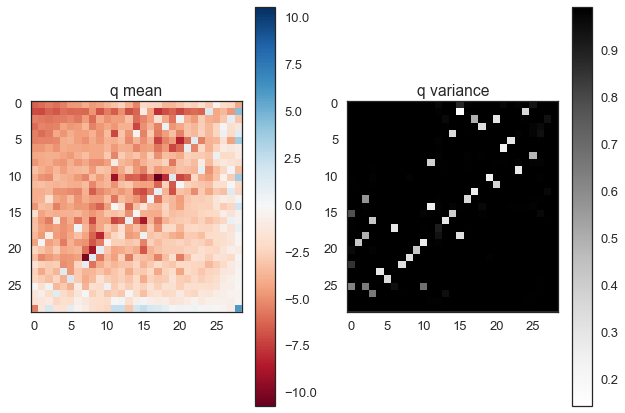

In [13]:
plt.figure()
plt.subplot(121)
plt.imshow(q_mu, interpolation="none", 
           vmin=-abs(q_mu).max(), 
           vmax=abs(q_mu).max(), 
           cmap="RdBu")
plt.title("q mean")
plt.colorbar()

plt.subplot(122)
plt.imshow(q_sigma, interpolation="none")
plt.title("q variance")
plt.colorbar()


                 

In [25]:
print("log p(y | x, P_{true}):       ", log_prob(P_true, 0))
print("log p(y | x, P_{map}):        ", log_prob(P_map, 0))

q_probs = []
for s in range(N_sample):
    Psi_sample = q_mu + npr.randn(K - 1, K - 1) * q_sigma
    B_sample = psi_to_birkhoff(logistic(Psi_sample / temperature(num_adam_iters)))
    P_sample = birkhoff_to_perm(B_sample)
    q_probs.append(log_prob(P_sample, 0))
q_probs = np.array(q_probs)

print("log E_{q(P)} [p(y | x, P)]:   ", -np.log(N_sample) + logsumexp(q_probs))
print("min_{P~q(P)} log p(y | x, P): ", np.min(q_probs))
print("max_{P~q(P)} log p(y | x, P): ", np.max(q_probs))

log p(y | x, P_{true}):        -46.2700685592
log p(y | x, P_{map}):         -29.3305682349
log E_{q(P)} [p(y | x, P)]:    -35.1582267349
min_{P~q(P)} log p(y | x, P):  -126.863698792
max_{P~q(P)} log p(y | x, P):  -29.3305682349


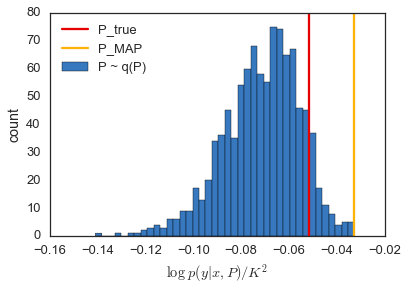

In [34]:
plt.hist(q_probs / K**2, 40, color=colors[1], label="P ~ q(P)")
yl = plt.ylim()
plt.plot(log_prob(P_true, 0) / K**2 * np.ones(2), yl, 
         c=colors[0], label="P_true")
plt.plot(log_prob(P_map, 0) / K**2 * np.ones(2), yl, 
         c=colors[2], label="P_MAP")
plt.ylim(yl)
plt.legend(loc="upper left")
plt.xlabel("$\\mathrm{log} \; p(y | x, P) / K^2 $")
plt.ylabel("count")